# Semester Project in Distributed Algorithms by Raphael Duarte and Thomas Riedl

## Implementation of Distributed Depth-First-Search with gRPC and Docker

In [1]:
import yaml
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#own module
import dfs_containerization as dfs_con
import subprocess


# specify the graph of distributed nodes with edge list, all used nodes will be part of the graph
edge_list = [[1,7], [1,2], [1,4], [1,6],
             [2,1], [2,4], [2,3],
             [3,2], [3,4], [3,6], [3,5], [3,7], [3,8], [3,10],
             [4,1], [4,2], [4,3],[4,6], 
             [5,1], [5,3], [5,7],
             [6,4], [6,3], [6,10],
             [7,5], [7,3], [7,8],
             [8,3], [8,7],
             [10,3],[10,6]]

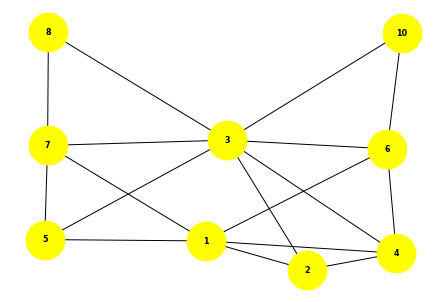

In [2]:
#plot the input graph
dfs_con.plot_input_graph(edge_list)

In [3]:
# create an overview of neigbours for each node of the graph and save result as "neighbours.yml"
dfs_con.get_neigbours_yaml(edge_list)

direct neighbours for each node:
{1: [7, 6, 5, 4, 2], 2: [4, 3, 1], 3: [10, 8, 7, 6, 5, 4, 2], 4: [6, 3, 2, 1], 5: [7, 3, 1], 6: [10, 4, 3, 1], 7: [8, 5, 3, 1], 8: [7, 3], 10: [6, 3]}


In [4]:
# specify which IP addresses should be used for the different containers in "ip_configuration.yml"
with open("ip_configuration.yml",'r') as file_ip:
    dict_ip = yaml.safe_load(file_ip)
    print("provided IP configuration for a graph of up to 10 nodes:")
    print(dict_ip)

provided IP configuration for a graph of up to 10 nodes:
{1: '172.20.0.11', 2: '172.20.0.12', 3: '172.20.0.13', 4: '172.20.0.14', 5: '172.20.0.15', 6: '172.20.0.16', 7: '172.20.0.17', 8: '172.20.0.18', 9: '172.20.0.19', 10: '172.20.0.20', 'subnet': '172.20.0.0/24'}


In [5]:
#Setup which port should be used for the gRPC communication between the nodes
PORT = 50051

# setup each node as docker container by generating a docker-compose file
nodes=dfs_con.write_docker_compose_yml(edge_list, PORT)

Initialization of Node 1:
{'build': {'context': '.', 'args': {'PORT': 50051, 'NODE_ID': 1}}, 'networks': {'frontend': {'ipv4_address': '172.20.0.11'}}, 'command': "/bin/sh -c 'python3 dfs_server.py'", 'container_name': 'node1', 'volumes': ['./output:/grpc-docker/ddfs/output']}


In [6]:
# build docker images of each Node according to generated docker-compose.yml file
!docker-compose build


Building n1
Sending build context to Docker daemon  1.318MB
Step 1/12 : FROM ubuntu:latest
 ---> 6b7dfa7e8fdb
Step 2/12 : RUN apt-get update && apt-get install -y python3 python3-pip
 ---> Using cache
 ---> e65a308509b5
Step 3/12 : COPY ./requirements_docker.txt /requirements_docker.txt
 ---> Using cache
 ---> d1691fa95ca7
Step 4/12 : RUN pip3 install -r /requirements_docker.txt
 ---> Using cache
 ---> 58cb7d8c2d59
Step 5/12 : RUN mkdir /grpc-docker
 ---> Using cache
 ---> 82d50d1caa08
Step 6/12 : COPY . /grpc-docker
 ---> 02c543a6a9be
Step 7/12 : WORKDIR /grpc-docker/ddfs
 ---> Running in 3f328abab187
Removing intermediate container 3f328abab187
 ---> 7dd7100d7324
Step 8/12 : ARG PORT
 ---> Running in 8d59aef3b627
Removing intermediate container 8d59aef3b627
 ---> 2fecd26fb8c1
Step 9/12 : ENV PORT "${PORT}"
 ---> Running in f54c93efb425
Removing intermediate container f54c93efb425
 ---> 78982cba64ab
Step 10/12 : ARG NODE_ID
 ---> Running in c0d4cd465d7d
Removing intermediate container

 ---> Running in ba12a7b46645
Removing intermediate container ba12a7b46645
 ---> b8a330eae465
Step 12/12 : RUN ["python3", "-m",  "grpc_tools.protoc" ,"-I." ,"--python_out=.",  "--pyi_out=.", "--grpc_python_out=.", "dfs.proto"]
 ---> Running in c910991592dc
Removing intermediate container c910991592dc
 ---> 5722804d2663
Successfully built 5722804d2663
Successfully tagged distributeddfs_n6:latest
Building n7
Sending build context to Docker daemon  1.318MB
Step 1/12 : FROM ubuntu:latest
 ---> 6b7dfa7e8fdb
Step 2/12 : RUN apt-get update && apt-get install -y python3 python3-pip
 ---> Using cache
 ---> e65a308509b5
Step 3/12 : COPY ./requirements_docker.txt /requirements_docker.txt
 ---> Using cache
 ---> d1691fa95ca7
Step 4/12 : RUN pip3 install -r /requirements_docker.txt
 ---> Using cache
 ---> 58cb7d8c2d59
Step 5/12 : RUN mkdir /grpc-docker
 ---> Using cache
 ---> 82d50d1caa08
Step 6/12 : COPY . /grpc-docker
 ---> Using cache
 ---> 02c543a6a9be
Step 7/12 : WORKDIR /grpc-docker/ddfs
 --

In [7]:
# start all created docker images as docker containers
# the protocol buffers are being built with start up
# the required code for DDFS is launched with start up (dfs_server.py)
!docker-compose up -d

Recreating node5 ... 
Recreating node2 ... 
Recreating node10 ... 
Recreating node4  ... 
Recreating node1  ... 
Recreating node3  ... 
Recreating node7  ... 
Recreating node6  ... 
Recreating node8  ... 
eating node6  ... done

In [10]:
# start the DDFS on the root node
ROOT = 1
# enter the desired docker container and run dfs_client.py which will start the DDFS with the current node as root
root = 'node{}'.format(ROOT)
!docker exec {root} python3 dfs_client.py


Root:  1
Will try to greet world ...
Connected to server: Hello, 1! from 1 successfully.
Greeted Neighbour: Hello, 1! from 2
Child: 10 Parent: 6
Child: 6 Parent: 4
Child: 8 Parent: 7
Child: 7 Parent: 5
Child: 4 Parent: 3
Child: 5 Parent: 3
Child: 3 Parent: 2
Child: 2 Parent: 1


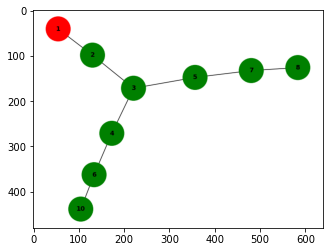

In [11]:
#plot the minimum spanning tree (saved in output/mst.png)
plt.imshow(plt.imread("../output/spanning_tree_root_{}.png".format(ROOT)))
plt.show()

Root:  5
Will try to greet world ...
Connected to server: Hello, 5! from 5 successfully.
Greeted Neighbour: Hello, 5! from 1
Child: 10 Parent: 6
Child: 6 Parent: 4
Child: 8 Parent: 7
Child: 4 Parent: 3
Child: 7 Parent: 3
Child: 3 Parent: 2
Child: 2 Parent: 1
Child: 1 Parent: 5


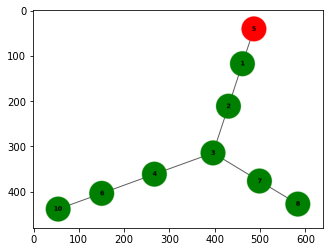

In [14]:
# use a different Node as Root
# start the DDFS on the root node
ROOT = 5
# enter the desired docker container and run dfs_client.py which will start the DDFS with the current node as root
root = 'node{}'.format(ROOT)
!docker exec {root} python3 dfs_client.py
plt.imshow(plt.imread("../output/spanning_tree_root_{}.png".format(ROOT)))
plt.show()

In [15]:
#kill the used docker containers
node_string = ''
for n in nodes:
    node_string = node_string + 'node{} '.format(int(n))
! docker kill {node_string}



node1
node2
node3
node4
node5
node6
node7
node8
node10
